In [2]:
import shutil
import struct
import scipy
from utilities.utility_functions import *
from astropy.io import fits
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
import xlrd
import pandas as pd
import itertools
from astropy.table import Table, Column, MaskedColumn, vstack, hstack
from astropy.io import ascii
import datetime
from os.path import join as pjoin
from scipy.optimize import fsolve
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm

In [3]:
def compare_ToutfixedWfixed(T_out_fixed=20, T_max=70, W_out_fixed=1.70*10**-5, T_air=0, S_t=2.337 / 100, phi_compare=.1):
    """
    This computes FOM by fixing T_out (essentially limited by the air temp and then solving for everything else.
    :param Q_fixed:
    :param T_max:
    :param deltaT:
    :param T_air:
    :param S_t:
    :param phi_compare:
    :return:
    """
    # data_loc file produced from /basic_model191203.py
    data = ascii.read(pjoin(data_loc, 'data_extract.csv'), format='csv')

    L_t = 6.510 / 100
    D_t = 1.825 / 100
    D_h = .8666 * S_t ** 2 / np.pi / D_t - D_t / 4
    D_hp = D_h  # (4*(S_t ** 2-(D_t/4)**2*np.pi))/(4*np.pi*D_t+D_h)
    PoD = S_t / D_t
    A_c = S_t ** 2 - (D_t / 2) ** 2 * np.pi
    A_s = np.pi * D_t * L_t
    data['T_out'] = T_out_fixed
    data['psi_c'] = .9090 + .0783 * PoD - .1283 * np.exp(-2.4 * (PoD - 1))
    mu_ratio = 1
    print(T_out_fixed)

    data['Velocity'] = (W_out_fixed*D_h*D_hp*2*(162 * (PoD - 1) ** .435*L_t*A_c*data['mu_nf'])**-1)**.5
    Reynolds = np.divide(data['rho_nf'], data['mu_nf']) * data['Velocity'] * D_h
    Prandtl = np.divide(np.multiply(data['c_nf'], data['mu_nf']), data['k_nf'])
    data['m_flowrate'] = data['rho_nf'] * A_c * data['Velocity']

    data['W_out'] = 162 * (PoD - 1) ** .435 * (Reynolds) ** -1 * data['rho_nf'] * (L_t / (2 * D_hp)) * data['Velocity'] ** 2 * data[
        'm_flowrate'] * data['rho_nf'] ** -1

    print( data['Velocity'][0:3])
    print( data['W_out'][0:3])

    data['htc'] = .128 * mu_ratio ** .14 * data['psi_c'] * np.multiply(np.multiply(Prandtl ** .4, Reynolds ** .6),
                                                                       data['k_nf']) / D_h
    data['Q_out'] = A_s*data['htc']*(T_max-T_out_fixed)

    deltaT = np.divide(data['Q_out'], (data['c_nf'] * data['rho_nf'] * A_c *data['Velocity']))
    data['deltaT'] = deltaT

    data['Q_out_check'] = data['c_nf'] * data['m_flowrate'] * (deltaT)

    data['W_out'] = 162 * (PoD - 1) ** .435 * (Reynolds) ** -1 * data['rho_nf'] * (L_t / (2 * D_hp)) * data['Velocity'] ** 2 * data[
        'm_flowrate'] * data['rho_nf'] ** -1
    data['Reynolds'] = Reynolds
    data['Prandtl'] = Prandtl

    data['T_in'] = data['T_out'] - deltaT
    logmeanT = deltaT * (np.log(np.divide(data['T_out'] - T_air, data['T_in'] - T_air))) ** -1

    data['FOM Q/W'] = np.divide(data['Q_out'], data['W_out'])
    data['FOM Simplified'] = np.divide(data['c_nf']**(2/5)*data['rho_nf']**(3/5)*data['k_nf']**(3/5), data['mu_nf']**(1/2))

    data['FOM Mouromtseff'] = data['rho_nf'] ** .8 * data['c_nf'] ** .33 * data['k_nf'] ** .67 / data['mu_nf'] ** .47
    data['Cmu : Ck'] = np.divide(np.divide(data['mu_nf'], data['mu_f']), np.divide(data['k_nf'], data['k_f']))
    data['T_outcheck'] = T_max - data['Q_out'] / (A_s * data['htc'])

    # look at phi = .10
    np.argmin(data['phi'] - phi_compare)

    # for each particle, grab highest performing

    name = 'T_out_fixed=' + str(T_out_fixed) + ', W_out_fixed=' + str(W_out_fixed)+', T_wall=' + str(T_max) + ', S_t=' + str(
        S_t) + ', T_air=' + str(T_air)

    save_loc = pjoin(data_loc,'Fixed_ToutWout')
    create_dir_safe(save_loc)
    if 1==0:
        ascii.write(data, pjoin(save_loc, 'data_extract'+name+'.csv'), format='csv',
                    fast_writer=True, overwrite=True)
        basic2d(data, 'phi', 'FOM Q/W', save_loc=save_loc, name='FOM -- ' + name, norm=1)
        basic2d(data, 'phi', 'FOM Simplified', save_loc=save_loc, name='FOM simple -- ' + name, norm=1)
        basic2d(data, 'phi', 'c_nf', save_loc=save_loc, name='c_nf -- ' + name, norm=0,axess=1)
        basic2d(data, 'phi', 'mu_nf', save_loc=save_loc, name='mu_nf -- ' + name, norm=0,axess=1)
        basic2d(data, 'phi', 'k_nf', save_loc=save_loc, name='k_nf -- ' + name, norm=0,axess=1)
        basic2d(data, 'phi', 'rho_nf', save_loc=save_loc, name='rho_nf -- ' + name, norm=0,axess=1)
        basic2d(data, 'phi', 'Q_out', save_loc=save_loc, name='Q_out -- ' + name, norm=0,axess=1)
        basic2d(data, 'phi', 'W_out', save_loc=save_loc, name='W_out -- ' + name, norm=0,axess=1)
        basic2d(data, 'phi', 'Velocity', save_loc=save_loc, name='Velocity -- ' + name, norm=0,axess=1)
        basic2d(data, 'phi', 'Reynolds', save_loc=save_loc, name='Reynolds -- ' + name, norm=0,axess=1)
        basic2d(data, 'phi', 'deltaT', save_loc=save_loc, name='deltaT -- ' + name, norm=0,axess=1)
        basic2d(data, 'phi', 'm_flowrate', save_loc=save_loc, name='m_flowrate -- ' + name, norm=0,axess=1)

    return data



In [4]:
data_loc = pjoin('/Users/hanscastorp/nanofluids/data/200204_sweep copy')

data = compare_ToutfixedWfixed(T_out_fixed=10, T_max=40, W_out_fixed=0.000126246, T_air=0, S_t=2.337 / 100)


10
      Velocity      
--------------------
0.023131111759881473
0.023131111759881473
0.023131111759881473
   W_out   
-----------
0.000126246
0.000126246
0.000126246


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log


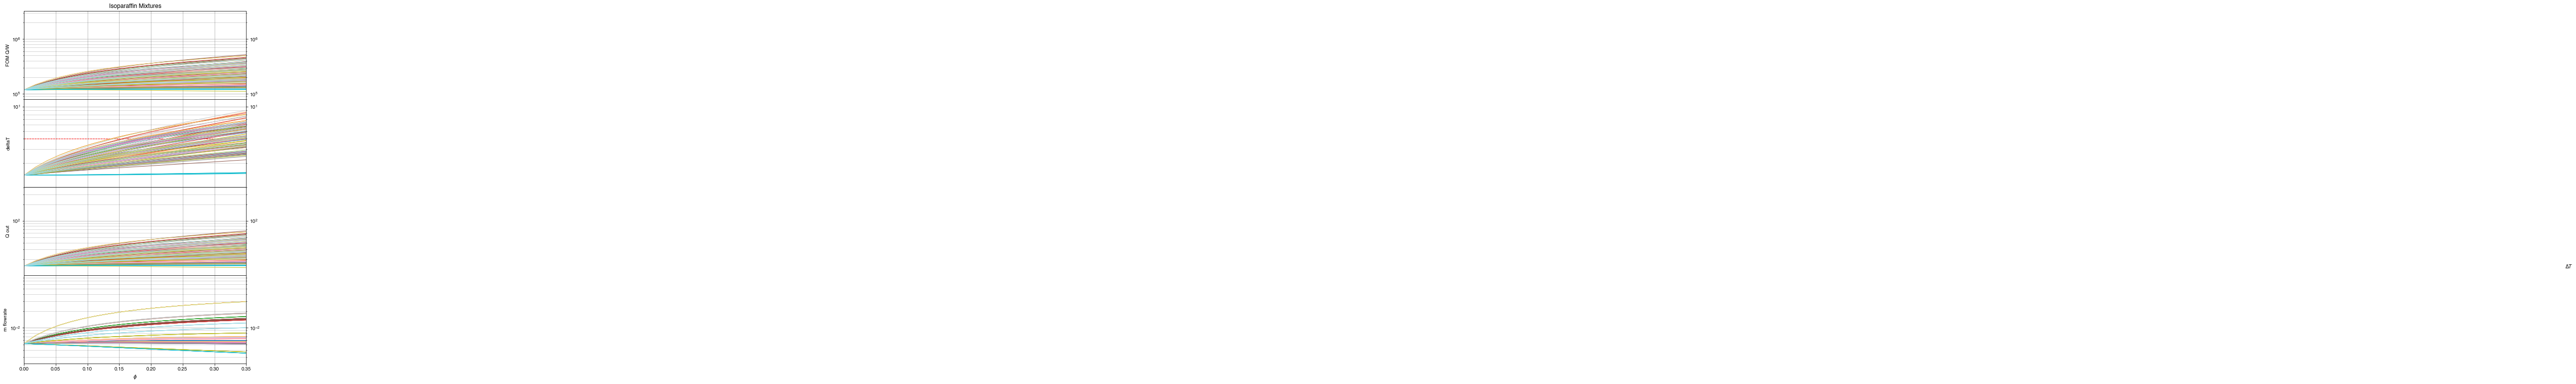

In [10]:
def basic2d_single(data, x, ys, save_loc, name='', norm=1,fluid= 0):
    """
    Function for plotting many variables for single fluid
    :param data:
    :param x:
    :param y:
    :param save_loc:
    :param name:
    :param norm:
    :param axess:
    :return:
    """
    fluids_unq = np.unique(data['bf_id'])
    particles_unq = np.unique(data['np_id'])
    p_unq = np.unique(data['p'])

    colors = cm.tab20(np.linspace(0, 1, len(particles_unq)))

    # plt.figure(figsize=(13.0, 8.0), dpi=400)
    plt.figure(figsize=(8.0,13.0))
    plt.subplots_adjust(wspace=0, hspace=0)

    if norm == 1:
        normer = data[data["phi"] == 0][y][0]
    else:
        normer = 1
    fluids_unq = fluids_unq[[0]]

    for bfi, bf in enumerate(fluids_unq):

        for yi,y in enumerate(ys):
            plt.subplot(len(ys), 1, yi + 1)

            bf_data = data[data['bf_id'] == bf]
            for npi, nanop in enumerate(particles_unq):
                np_data = bf_data[bf_data['np_id'] == nanop]

                for pi, pppp in enumerate(p_unq):
                    pp_data = np_data[np_data['p'] == pppp]
                    if pi == 0:
                        plt.plot(pp_data[x], pp_data[y] / normer, lw=1, c=colors[npi], label=nanop.replace('_', ' '))
                    else:
                        plt.plot(pp_data[x], pp_data[y] / normer, lw=1, c=colors[npi], label='_nolegend_')

            #             plt.scatter(np_data[x],np_data[y]/normer,s=2,label=nanop)

            if x == 'phi' and yi==len(ys)-1:
                plt.xlabel('$\phi$')
            elif yi==len(ys)-1:
                plt.xlabel(x.replace('_', ' '))
            plt.xlim([0, .35])

            plt.ylabel(y.replace('_', ' '))
            plt.tick_params(which="both", axis='y', right='True', left='True', labelleft='True', labelright='True')


            if yi<len(ys)-1:
                plt.tick_params(which="both", axis='x',  labelbottom='False', 
                                bottom='False', )

            if y == 'deltaT':
                plt.hlines(4,0,.35,colors='r',linestyles='dashed',lw=1)
                plt.text(4, .1, '$\Delta T$', rotation=0)
                
            plt.ylim([np.nanpercentile(data[y]/normer,0),np.nanpercentile(data[y]/normer,100)])
            #         plt.ylim([.0001,.01])

            plt.yscale('log')
            ax = plt.gca()
            ax.set_yscale('log')
            plt.grid(which='minor', color='k', linestyle='-', alpha=0.2)
    
            plt.grid('on')
#             ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))
#             ax.yaxis.set_major_formatter(
#                 ticker.FuncFormatter(lambda y, pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y), 0)))).format(y)))
            if yi ==0:
                plt.title(bf)

    plt.savefig(pjoin(save_loc, name + '--' + x + '_vs_' + 'FOM' + '_22.png'))
    return
save_loc = '/Users/hanscastorp/Downloads'
name= 'blah2'
basic2d_single(data, 'phi', ['FOM Q/W','deltaT','Q_out','m_flowrate'], save_loc=save_loc, name='FOM -- ' + name,
               norm=[1,0,0,0])




In [46]:

def compare_Qfixed(T_outs=np.linspace(-20,30,100), T_max=70, Q_out_fixed=10, T_air=0, S_t=2.337 / 100):
   
    # pick best performing nanofluid at phi = .1, and scan the Tout fixed space to get W,Tout,delta coordinates
    # data_loc file produced from /basic_model191203.py
    
    data_fluids = ascii.read('/Users/hanscastorp/nanofluids/data/data_1_bestperformers.csv', format='csv')

    L_t = 6.510 / 100
    D_t = 1.825 / 100
    D_h = .8666 * S_t ** 2 / np.pi / D_t - D_t / 4
    D_hp = D_h  # (4*(S_t ** 2-(D_t/4)**2*np.pi))/(4*np.pi*D_t+D_h)
    PoD = S_t / D_t
    A_c = S_t ** 2 - (D_t / 2) ** 2 * np.pi
    A_s = np.pi * D_t * L_t
    mu_ratio = 1
    
    # each fluid requries its own data set
    # so array is fluids x 3 for T_out, W, deltaT
    
    
    fluid_names = [data_fluids['np_id'][f]+ ':'+data_fluids['bf_id'][f] for f in range(data_fluids['np_id'].size)][0:2]
    data_fluids= data_fluids[0:2]
    
    data_WTdT = np.zeros((len(fluid_names),3,T_outs.size)) # fluids, (W,T,dT), Tout
    for fi,fluid in enumerate(fluid_names):
        
        data= vstack([data_fluids[fi] for ll in range(T_outs.size)])
        if 1==1:
            data['T_out'] = T_outs
                    
            data['psi_c'] = .9090 + .0783 * PoD - .1283 * np.exp(-2.4 * (PoD - 1))


            data['Velocity'] = (Q_out_fixed/(A_s*(T_max-data['T_out']))*(.128 * mu_ratio ** .14 * data['psi_c'] *np.multiply(np.multiply((np.divide(np.multiply(data['c_nf'], data['mu_nf']), data['k_nf'])) ** .4,
                                                           (np.divide(data['rho_nf'], data['mu_nf']) * D_h) ** .6),
                                                                           data['k_nf']) / D_h)**-1)**(5/3)

            deltaT = np.divide(Q_out_fixed , (data['c_nf'] * data['rho_nf'] * A_c *data['Velocity']))
            data['deltaT'] = deltaT

            Reynolds = np.divide(data['rho_nf'], data['mu_nf']) * data['Velocity'] * D_h
            Prandtl = np.divide(np.multiply(data['c_nf'], data['mu_nf']), data['k_nf'])

            data['m_flowrate'] = data['rho_nf'] * A_c * data['Velocity']

            data['htc'] = .128 * mu_ratio ** .14 * data['psi_c'] * np.multiply(np.multiply(Prandtl ** .4, Reynolds ** .6),
                                                                               data['k_nf']) / D_h
            data['Q_out'] = data['c_nf'] * data['m_flowrate'] * (deltaT)

            data['Q_out_check'] = A_s*data['htc']*(T_max-data['T_out'])
            data['W_out'] = 162 * (PoD - 1) ** .435 * (Reynolds) ** -1 * data['rho_nf'] * (L_t / (2 * D_hp)) * data['Velocity'] ** 2 * data[
                'm_flowrate'] * data['rho_nf'] ** -1
            data['Reynolds'] = Reynolds
            data['Prandtl'] = Prandtl

            data['T_in'] = data['T_out'] - deltaT
            logmeanT = deltaT * (np.log(np.divide(data['T_out'] - T_air, data['T_in'] - T_air))) ** -1

            data['FOM Q/W'] = np.divide(data['Q_out'], data['W_out'])
            data['FOM Simplified'] = np.divide(data['c_nf']**(4/3)*data['rho_nf']**(2)*data['k_nf']**(2), data['mu_nf']**(5/3))

            data['FOM Mouromtseff'] = data['rho_nf'] ** .8 * data['c_nf'] ** .33 * data['k_nf'] ** .67 / data['mu_nf'] ** .47
            data['Cmu : Ck'] = np.divide(np.divide(data['mu_nf'], data['mu_f']), np.divide(data['k_nf'], data['k_f']))
            data['T_outcheck'] = T_max - data['Q_out'] / (A_s * data['htc'])


        # fluids, (W,T,dT), Tout
        data_WTdT[fi,0,:] = np.array(data['W_out'])
        data_WTdT[fi,1,:] = np.array(data['T_out'])
        data_WTdT[fi,2,:] = np.array(data['deltaT'])
    return fluid_names,data_WTdT

fluid_names, dataFluidX3 = compare_Qfixed(T_outs=np.linspace(-20,30,100), T_max=70, Q_out_fixed=10, T_air=0, S_t=2.337 / 100)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in log


In [48]:
# plot the data in 3d space to show each fluid is different
print(fluid_names)
print(dataFluidX3.shape)

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
for fi,fluid in enumerate(fluid_names):
    ax.plot(dataFluidX3[dataFluidX3[fi,0,:], dataFluidX3[fi,1,:], dataFluidX3[fi,2,:], label= fluid)
ax.legend()
ax.set_xlabel('$\dot{W} Pumping Power')
ax.set_ylabel('$T_{out}$')
ax.set_zlabel('$\Delta T_{max}$')
              

plt.show()



['Au:Isoparaffin Mixtures', 'W:Isoparaffin Mixtures']
(2, 3, 100)
